In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2023-11-20 14:08:27.764802: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 14:08:27.767498: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 14:08:27.800011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 14:08:27.800041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 14:08:27.800779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
print(tf.__version__)

2.15.0


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [10]:
train_df = pd.read_csv('data/train.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# Chapter 13 

## 13.1 Creating windows of data
### 13.1.1 Exploring how deep learning models are trained for time series forecasting

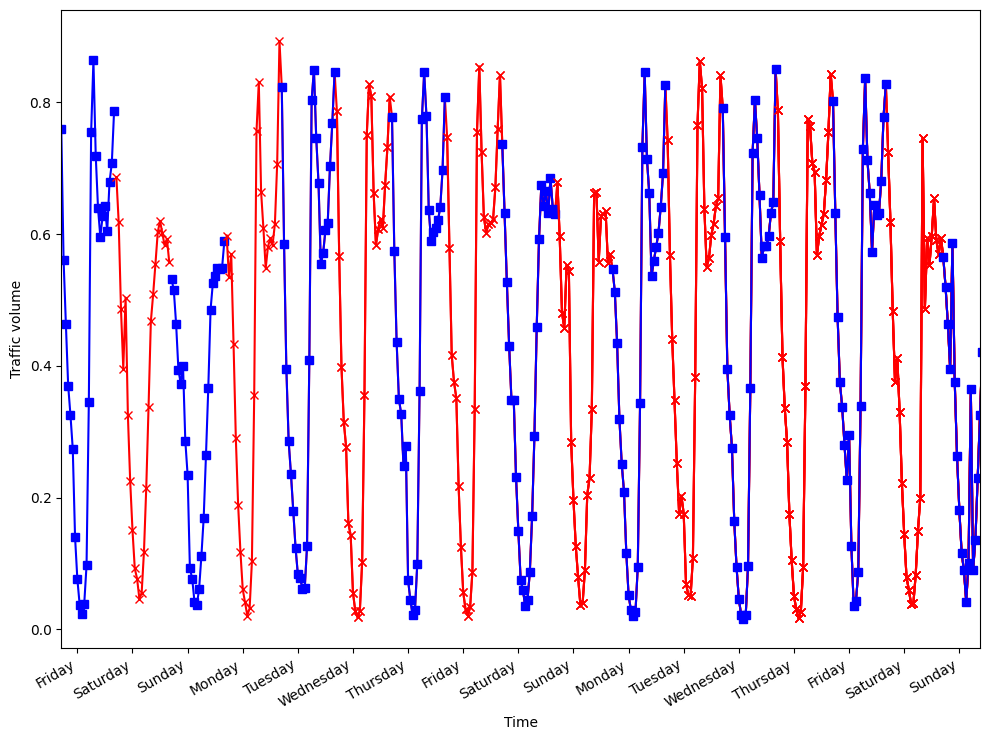

In [11]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH13_F01_peixeiro.png', dpi=300)

### 13.1.2 Implementing the `DataWindow` class 

In [13]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## 13.2 Applying baseline models
### 13.2.1 Single-step baseline model

In [14]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [15]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [16]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [17]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 1s 1ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


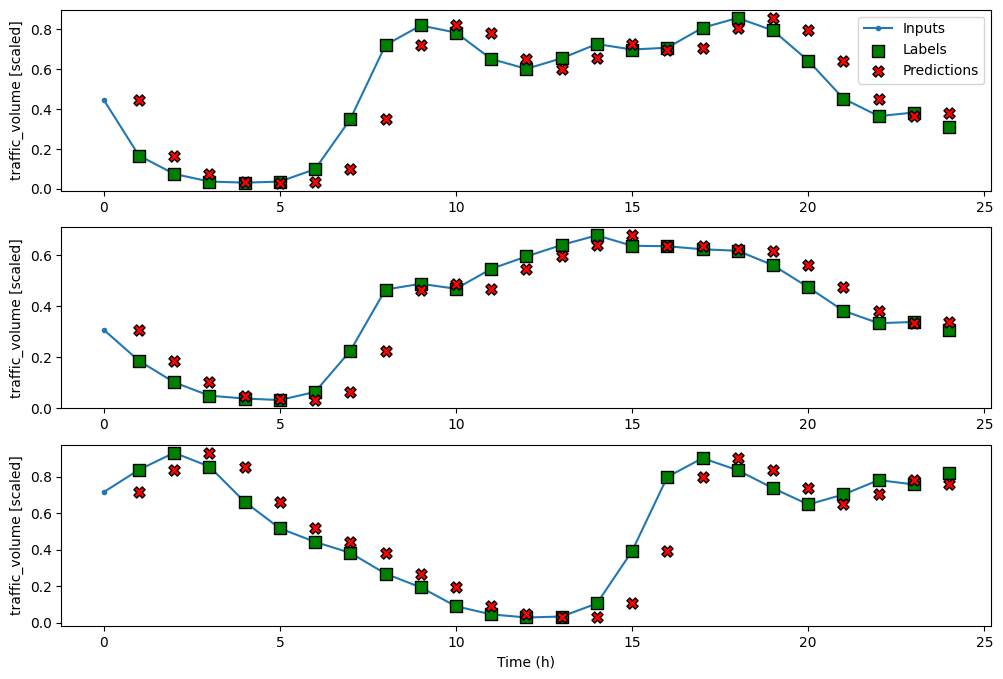

In [19]:
wide_window.plot(baseline_last)

plt.savefig('CH13_F09_peixeiro.png', dpi=300)

In [20]:
print(performance['Baseline - Last'][1])

0.08128400146961212


### 13.2.2 Multi-step baseline models 

In [21]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

#### Predicting the last known value 

In [22]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [32]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 870us/step - loss: 0.1875 - mean_absolute_error: 0.3522


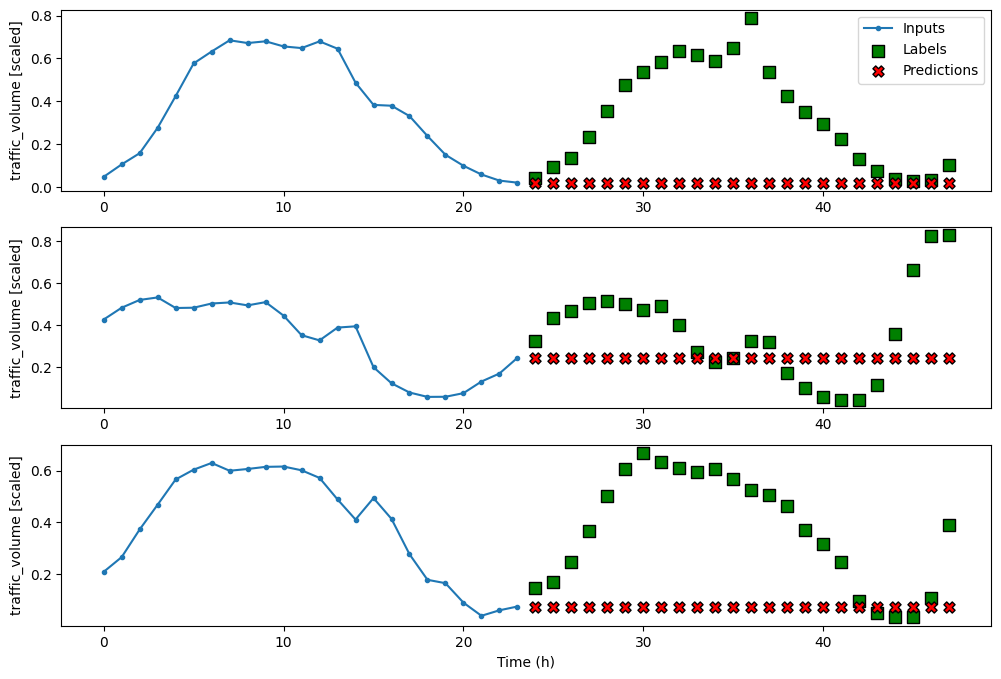

In [33]:
multi_window.plot(ms_baseline_last)

plt.savefig('CH13_F10_peixeiro.png', dpi=300)

In [25]:
print(ms_performance['Baseline - Last'][1])

0.3472607135772705


#### Repeating the input sequence 

In [34]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [35]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 920us/step - loss: 0.2065 - mean_absolute_error: 0.3473


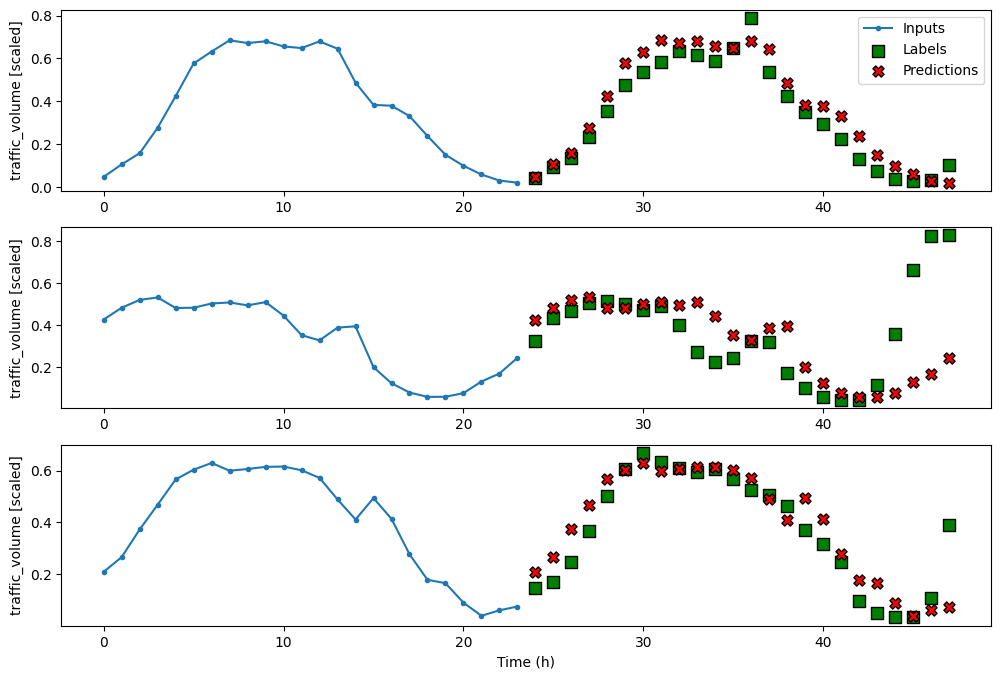

In [36]:
multi_window.plot(ms_baseline_repeat)

#plt.savefig('figures/CH13_F11_peixeiro.png', dpi=300)

In [37]:
print(ms_performance['Baseline - Repeat'][1])

0.34127721190452576


### 13.2.3 Multi-output baseline model 

In [38]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [39]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [40]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0482


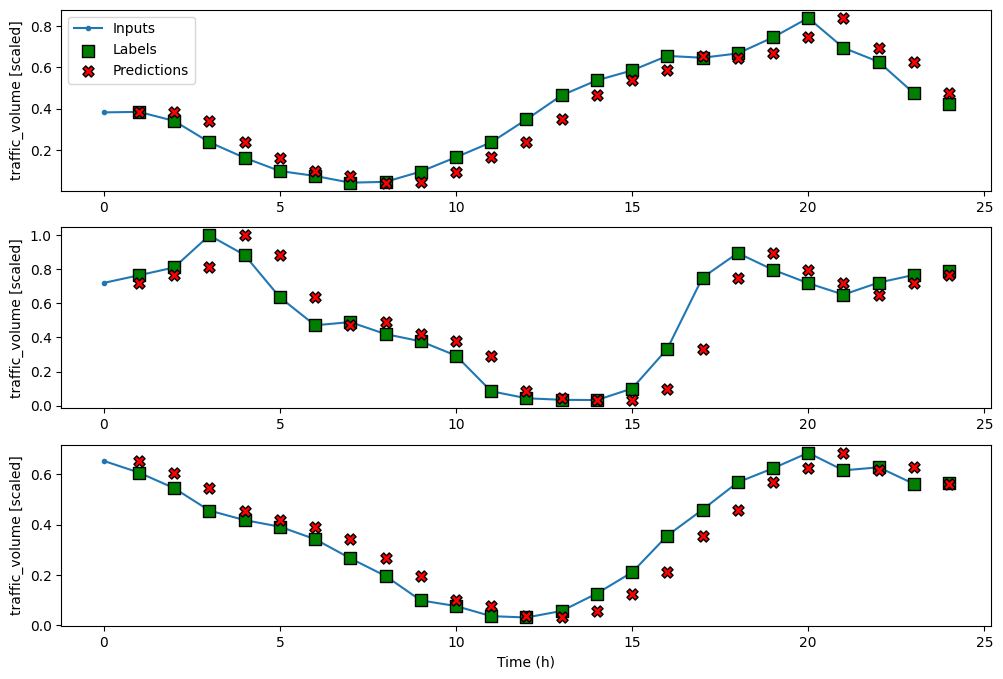

In [41]:
mo_wide_window.plot(mo_baseline_last)

#plt.savefig('figures/CH13_F12_peixeiro.png', dpi=300)

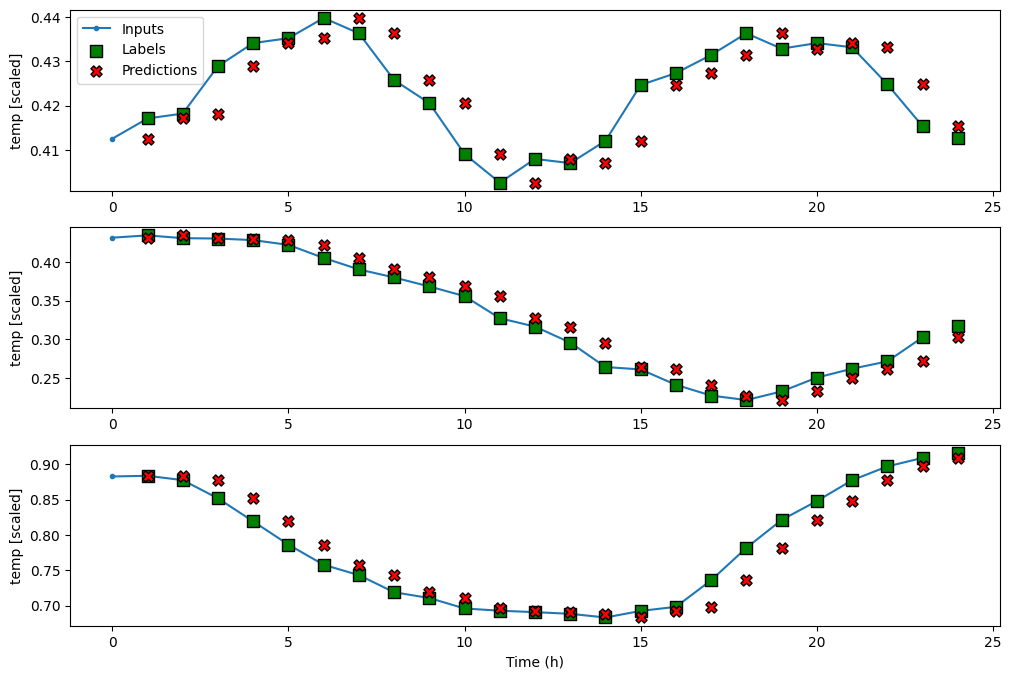

In [42]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

#plt.savefig('figures/CH13_F13_peixeiro.png', dpi=300)

In [29]:
print(mo_performance['Baseline - Last'][1])

0.04710667207837105


# Chapter 14 

## 14.1 Implementing a linear model
### 14.1.1 Building a single-step linear model

In [26]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [28]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.2407 - mean_absolute_error: 0.3890 - val_loss: 0.1672 - val_mean_absolute_error: 0.3320
Epoch 2/50
384/384 [==============================] - 0s 1ms/step - loss: 0.1194 - mean_absolute_error: 0.2739 - val_loss: 0.0955 - val_mean_absolute_error: 0.2529
Epoch 3/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0684 - mean_absolute_error: 0.2057 - val_loss: 0.0601 - val_mean_absolute_error: 0.2008
Epoch 4/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0443 - mean_absolute_error: 0.1655 - val_loss: 0.0419 - val_mean_absolute_error: 0.1669
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0317 - mean_absolute_error: 0.1400 - val_loss: 0.0308 - val_mean_absolute_error: 0.1419
Epoch 6/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0240 - mean_absolute_error: 0.1210 - val_loss: 0.0236 - val_mean_absolute_error: 0.1235
Epoch 7/50
384/3

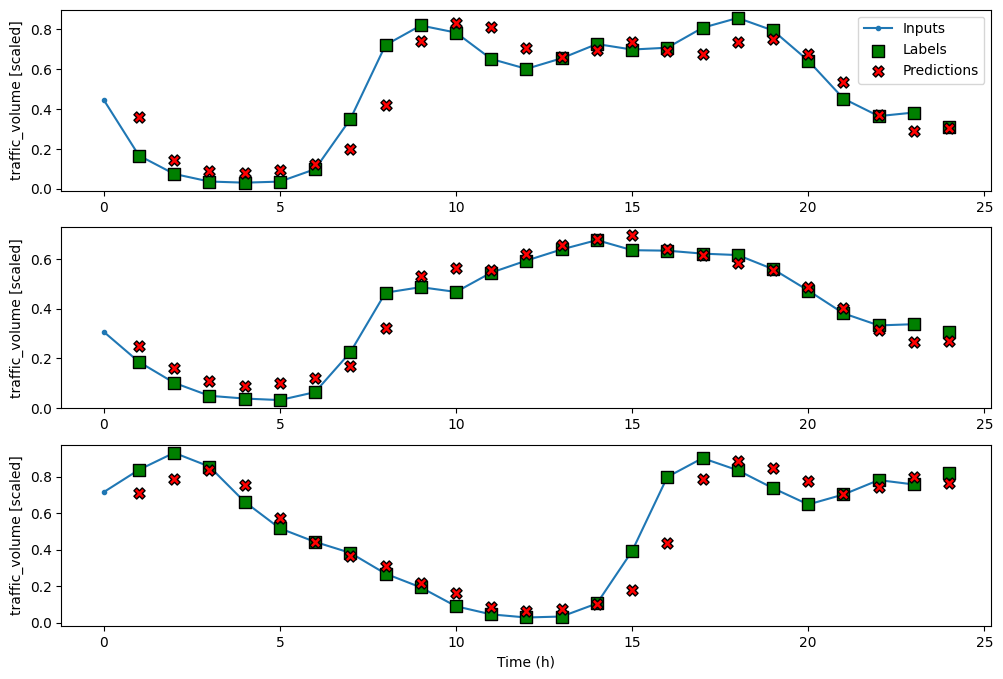

In [29]:
wide_window.plot(linear)

#plt.savefig('figures/CH14_F02_peixeiro.png', dpi=300)

### 14.1.2 Building a mutli-step linear model 

In [30]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0900 - mean_absolute_error: 0.2467 - val_loss: 0.0458 - val_mean_absolute_error: 0.1821
Epoch 2/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0298 - mean_absolute_error: 0.1369 - val_loss: 0.0261 - val_mean_absolute_error: 0.1252
Epoch 3/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0201 - mean_absolute_error: 0.1044 - val_loss: 0.0213 - val_mean_absolute_error: 0.1074
Epoch 4/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0177 - mean_absolute_error: 0.0954 - val_loss: 0.0196 - val_mean_absolute_error: 0.1001
Epoch 5/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0168 - mean_absolute_error: 0.0914 - val_loss: 0.0189 - val_mean_absolute_error: 0.0958
Epoch 6/50
383/383 [==============================] - 0s 1ms/step - loss: 0.0164 - mean_absolute_error: 0.0887 - val_loss: 0.0185 - val_mean_absolute_error: 0.0924
Epoch 7/50
383/3

### 14.1.3 Implementing a multi-output linear model 

In [43]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.9447 - mean_absolute_error: 0.8337 - val_loss: 0.3735 - val_mean_absolute_error: 0.5127
Epoch 2/50
384/384 [==============================] - 1s 1ms/step - loss: 0.1996 - mean_absolute_error: 0.3628 - val_loss: 0.1385 - val_mean_absolute_error: 0.3033
Epoch 3/50
384/384 [==============================] - 0s 1ms/step - loss: 0.1143 - mean_absolute_error: 0.2753 - val_loss: 0.0875 - val_mean_absolute_error: 0.2400
Epoch 4/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0745 - mean_absolute_error: 0.2205 - val_loss: 0.0558 - val_mean_absolute_error: 0.1907
Epoch 5/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0471 - mean_absolute_error: 0.1738 - val_loss: 0.0356 - val_mean_absolute_error: 0.1520
Epoch 6/50
384/384 [==============================] - 0s 1ms/step - loss: 0.0302 - mean_absolute_error: 0.1378 - val_loss: 0.0236 - val_mean_absolute_error: 0.1236
Epoch 7/50
384/3

## 14.2 Implementing a deep neural network
### 14.2.1 Implementing a deep neural network as a single-step model

In [46]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0140 - mean_absolute_error: 0.0766 - val_loss: 0.0053 - val_mean_absolute_error: 0.0543
Epoch 2/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0050 - mean_absolute_error: 0.0520 - val_loss: 0.0060 - val_mean_absolute_error: 0.0604
Epoch 3/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0040 - mean_absolute_error: 0.0464 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425
Epoch 4/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0035 - mean_absolute_error: 0.0428 - val_loss: 0.0033 - val_mean_absolute_error: 0.0433
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0032 - mean_absolute_error: 0.0410 - val_loss: 0.0027 - val_mean_absolute_error: 0.0376
Epoch 6/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0031 - mean_absolute_error: 0.0398 - val_loss: 0.0025 - val_mean_absolute_error: 0.0362
Epoch 7/50
384/3

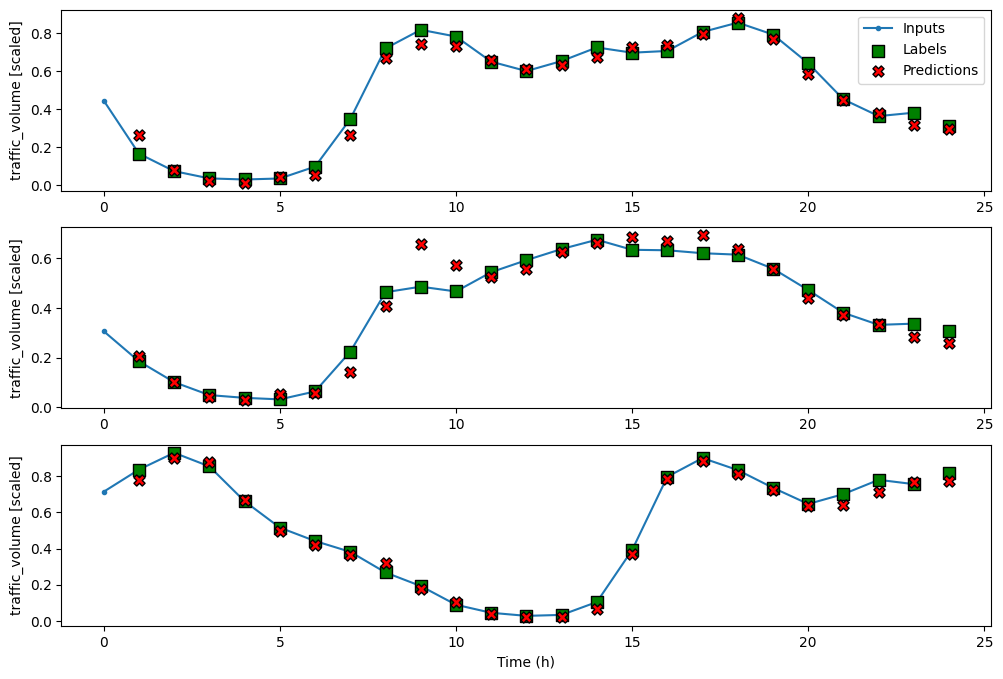

In [47]:
wide_window.plot(dense)

#plt.savefig('figures/CH14_F06_peixeiro.png', dpi=300)

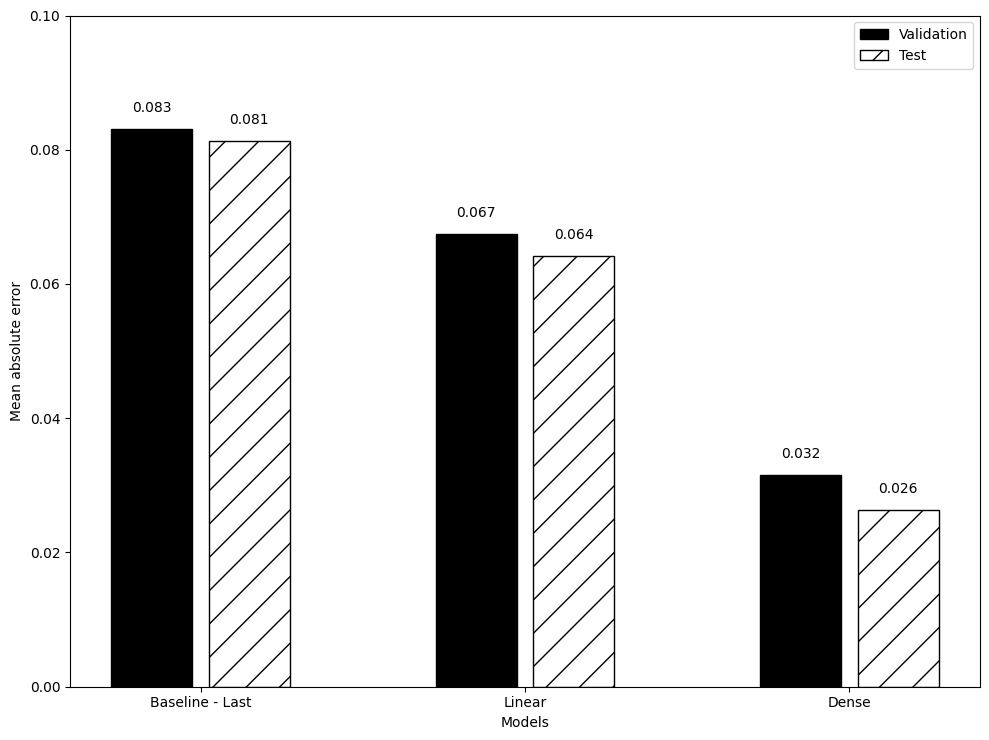

In [49]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

#plt.savefig('figures/CH14_F07_peixeiro.png', dpi=300)

### 14.2.2 Implementing a deep neural network as a multi-step model 

In [50]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0299 - mean_absolute_error: 0.1103 - val_loss: 0.0168 - val_mean_absolute_error: 0.0845
Epoch 2/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0144 - mean_absolute_error: 0.0790 - val_loss: 0.0161 - val_mean_absolute_error: 0.0836
Epoch 3/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0140 - mean_absolute_error: 0.0782 - val_loss: 0.0158 - val_mean_absolute_error: 0.0841
Epoch 4/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0775 - val_loss: 0.0158 - val_mean_absolute_error: 0.0853
Epoch 5/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0771 - val_loss: 0.0151 - val_mean_absolute_error: 0.0815
Epoch 6/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0765 - val_loss: 0.0149 - val_mean_absolute_error: 0.0812
Epoch 7/50
383/3

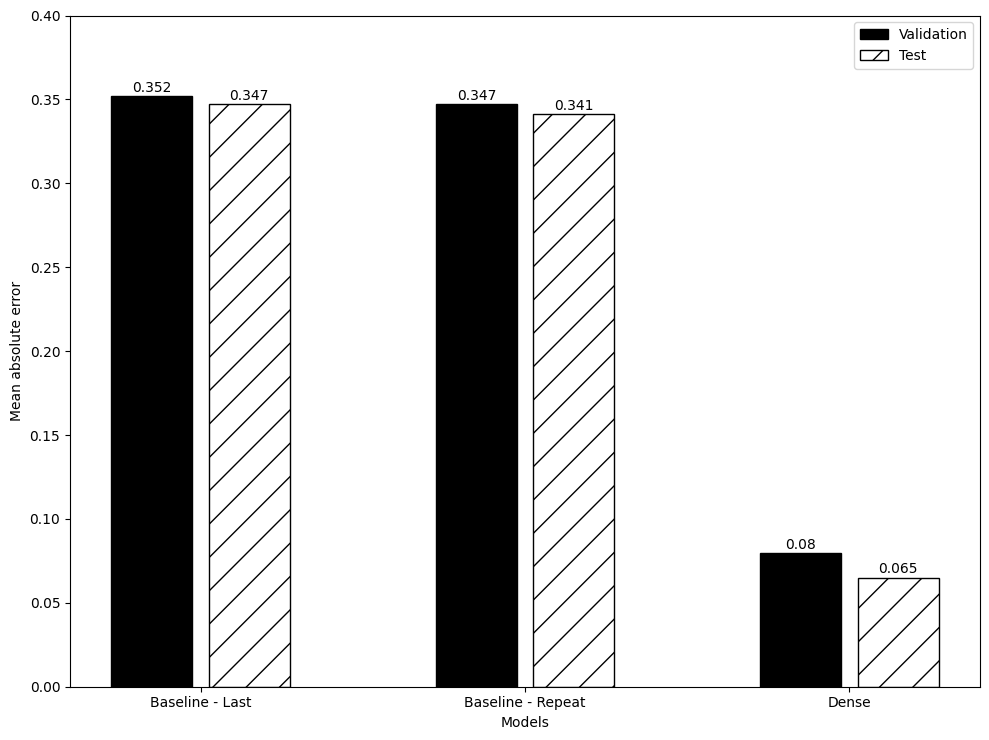

In [52]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

#plt.savefig('figures/CH14_F08_peixeiro.png', dpi=300)

### 14.2.3 Implementing a deep neural network as a multi-output model 

In [53]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0109 - mean_absolute_error: 0.0611 - val_loss: 0.0030 - val_mean_absolute_error: 0.0357
Epoch 2/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0029 - mean_absolute_error: 0.0337 - val_loss: 0.0022 - val_mean_absolute_error: 0.0296
Epoch 3/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_absolute_error: 0.0304 - val_loss: 0.0017 - val_mean_absolute_error: 0.0268
Epoch 4/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0021 - mean_absolute_error: 0.0286 - val_loss: 0.0017 - val_mean_absolute_error: 0.0276
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0277 - val_loss: 0.0017 - val_mean_absolute_error: 0.0274
Epoch 6/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0272 - val_loss: 0.0016 - val_mean_absolute_error: 0.0266
Epoch 7/50
384/3

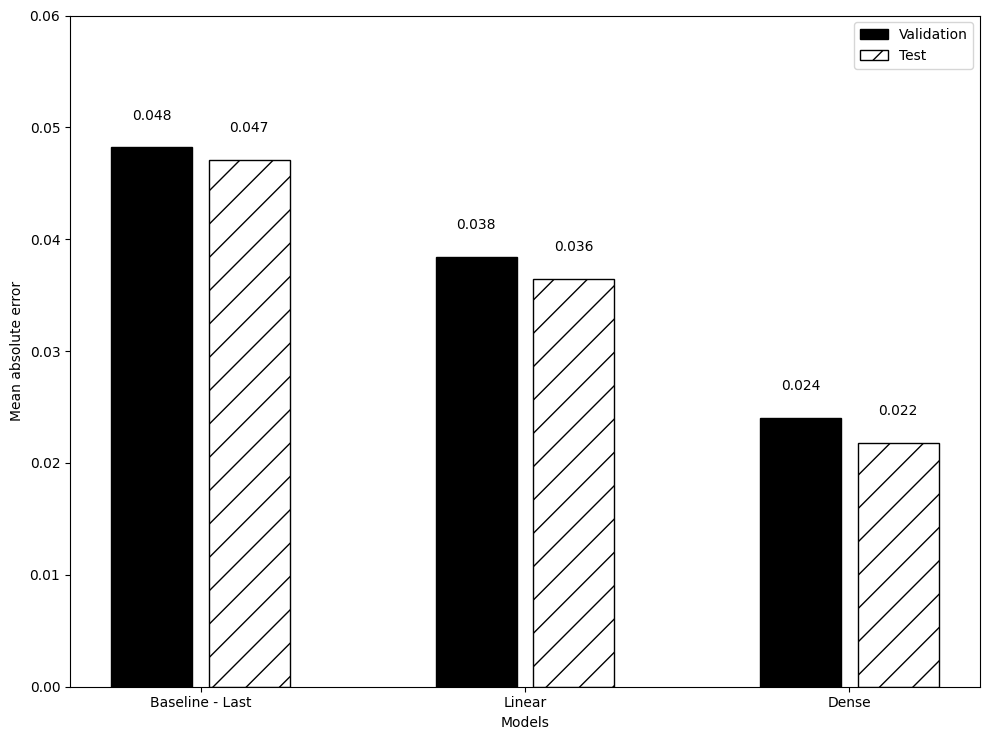

In [55]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

#plt.savefig('figures/CH14_F09_peixeiro.png', dpi=300)

In [69]:
df=pd.read_csv('data/metro_interstate_traffic_volume_preprocessed.csv',index_col=[0])
# df_d=pd.to_datetime(df['date_time'])
# df['date']=df_d
# df['date_time']=df['date']
# df.drop('date_time',axis=1,inplace=True)
# df.head()
df.index=pd.to_datetime(df.index)
df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


In [72]:
def create_features(df,label=None):
    df['date']=df.index
    df['hour']=df['date'].dt.hour
    df['dayofweek']=df['date'].dt.dayofweek
    df['quarter']=df['date'].dt.quarter
    df['month']=df['date'].dt.month
    df['year']=df['ywar'].dt.year
    df['dayofyear']=df['date'].dt.dayofyear
    df['dayofmonth']=df['date'].dt.day
    df['weekofyear']=df['date'].dt.weekofyear
    
    X=df[['hour','dayofweek','quarter','month','year',
          'dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y=df[label]
        return X,y
    return X

X=create_features(df)
    

KeyError: 'ywar'